In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [3]:
def gauss(x, mean = 0.0, var = 0.0001, amp = 1.0):
    return amp * np.exp(- (x - mean) ** 2 / (2 * var))



def signal_gauss(x, alpha0 = [0.01, -0.01], scale = 0.00001, amp = [1.0, 1.0]):
    result = 0
    for idx, pos in enumerate(alpha0):
        result += gauss(x, pos, scale, amp[idx])
    return result



def Fexp(alpha, n = 0, k = 2 * np.pi, d = 0.7, sign = 1):
    return np.exp(sign * 1j * alpha * n * k * d)



def Cn_deltaf_compute(n, k, d, alpha0 = [0.01, -0.01]):
    result = 0
    for target in alpha0:
        result += Fexp(target, n, k, d)
    return result



def U_compute(alpha, Cn, k, d):
    result = 0
    M = len(Cn)
    delta = (M - 1) // 2
    for n, C in enumerate(Cn):
        result += C * Fexp(alpha, n - delta, k, d, -1)
    return result

In [4]:
K = 25              # Реальное количество излучателей
NP = 400            # Виртуальное количество излучателей
k = 2 * np.pi       # Волновое число
d = 0.7             # Расстояние между излучателями

alpha = np.linspace(-0.02, 0.02, 2000)  # Угловое разрешение области
targets = [0.0010, -0.004]              # Положения целей
amplitude = [100, 200]                  # Интенсивности целей для отрисовки, на вычисления не влияют

In [5]:
n_real = np.arange(-K, K + 1)                 # Реальное перечисление номеров излучателей
n_virtual = np.arange(-NP, NP + 1)            # Идеальное (виртуальное) число излучателей

Cn_real = Cn_deltaf_compute(n_real, k, d, targets)              # Реальные Cn излучателей от -K до K включительно
Cn_virtual = Cn_deltaf_compute(n_virtual, k, d, targets)        # Виртуальные Cn излучателей (как хотим чтобы было)

# Для отрисовки целей
signals = signal_gauss(alpha, alpha0 = targets, scale = 0.00000005, amp = amplitude)  

# Реально принятый сигнал
U_real = U_compute(alpha, Cn_real, k, d)

# Как должно быть по факту
U_virtual = U_compute(alpha, Cn_virtual, k, d)

C:\ProgramData\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


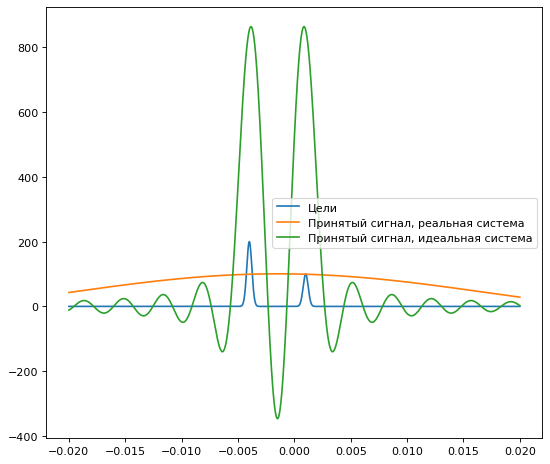

In [6]:
plt.figure(figsize = (8, 7), dpi = 80)
plt.plot(alpha, signals, label = "Цели")
plt.plot(alpha, U_real, label = "Принятый сигнал, реальная система")
plt.plot(alpha, U_virtual, label = "Принятый сигнал, идеальная система")
plt.legend()

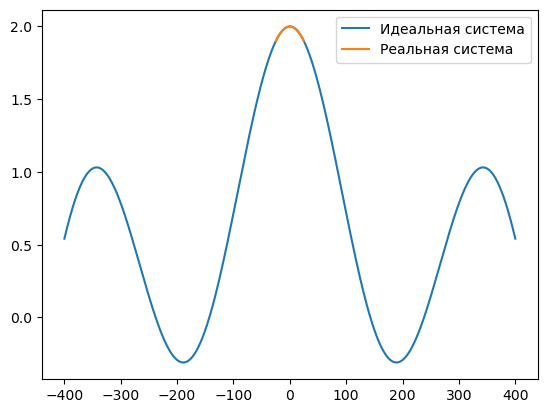

In [7]:
plt.plot(n_virtual, Cn_virtual, label = "Идеальная система")
plt.plot(n_real, Cn_real, label = "Реальная система")
plt.legend()

## Генерация выборки для обучения моделей

In [8]:
def create_data(number_of_samples = 10000, n_real = 20, n_virtual = 400, target_bounds = [-0.04, 0.04], 
                k = 1, d = 1, noised = False, noise_level = 0.4, seed = 123):
    data_x = np.zeros((2 * number_of_samples, n_real * 2 + 1)) + 0j
    data_y = np.zeros((2 * number_of_samples, n_virtual * 2 + 1)) + 0j
    
    np.random.seed(123)
    real = np.arange(-n_real, n_real + 1)                 # Реальное перечисление номеров излучателей
    virtual = np.arange(-n_virtual, n_virtual + 1)            # Идеальное (виртуальное) число излучателей

    for sample_num in np.arange(number_of_samples):
        targets = [np.random.uniform(target_bounds[0], target_bounds[0] * 0.1, 1),\
                  np.random.uniform(target_bounds[1] * 0.1, target_bounds[1], 1)]
        data_x[sample_num, :] = Cn_deltaf_compute(real, k, d, targets)
        data_y[sample_num, :] = Cn_deltaf_compute(virtual, k, d, targets)
    
    for sample_num in np.arange(number_of_samples):
        targets = []
        targets.append(np.random.uniform(target_bounds[0], target_bounds[0] * 0.1, 1))
        targets.append(np.abs(targets[0]))
        data_x[number_of_samples + sample_num, :] = Cn_deltaf_compute(real, k, d, targets)
        data_y[number_of_samples + sample_num, :] = Cn_deltaf_compute(virtual, k, d, targets)
    
    return data_x, data_y

In [10]:
X, Y = create_data(number_of_samples = 10000, k = k, d = d)
order = np.random.permutation(X.shape[0])
X = X[order]
Y = Y[order]

X_val, Y_val = create_data(number_of_samples = 1000, k = k, d = d)
order_val = np.random.permutation(X_val.shape[0])
X_val = X_val[order_val]
Y_val = Y_val[order_val]

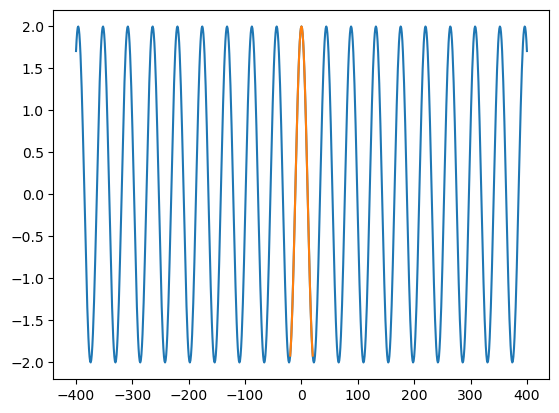

In [14]:
plt.plot(np.arange(-400, 401), np.real(Y[8002,:]))
plt.plot(np.arange(-20, 21), np.real(X[8002,:]))

## Инициализация модели нейросети

В данном коде создается класс RegressionNet, который наследуется от nn.Module и содержит методы init(), forward() и inference().

Первый метод init() инициализирует атрибуты объекта класса: input_size - размерность входа, hidden_size - количество нейронов в скрытых слоях, output_size - размерность выхода и dropout_prob - вероятность отключения нейронов в процессе обучения.

Затем создается последовательность трех полносвязных слоев с функцией активации tanh(), которая определена в модуле torch.nn.functional.

Tакже определен dropout-слоев, который применяется при обучении в методе forward().

Метод forward() принимает на вход тензор x и прогоняет его через полносвязные слои с применением dropout и функции активации.

Метод inference() принимает на вход тензор x и прогоняет его через полносвязные слои без применения dropout.

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class RegressionNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_prob)
        
    def forward(self, x):
        x = F.selu(self.fc1(x))
        x = self.dropout(x)
        x = F.selu(self.fc2(x))
        x = self.dropout(x)
        x = F.selu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x
    
    def inference(self, x):
        x = F.selu(self.fc1(x))
        x = F.selu(self.fc2(x))
        x = F.selu(self.fc3(x))
        x = self.fc4(x)
        return x

In [27]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

model_superresolution = RegressionNet(input_size = X.shape[1], hidden_size = 500, 
                                      output_size = Y.shape[1], dropout_prob = 0.00)
rate = 1e-4
batch_size = 100
num_epochs = 200

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_superresolution.parameters(), lr = rate)

optimizer.zero_grad()

X_tensor = torch.tensor(np.real(X), dtype = torch.float, device=device)
Y_tensor = torch.tensor(np.real(Y), dtype = torch.float, device=device)
X_val_tensor = torch.tensor(np.real(X_val), dtype = torch.float, device=device)
Y_val_tensor = torch.tensor(np.real(Y_val), dtype = torch.float, device=device)


model_superresolution.load_state_dict(torch.load("model_params"))

model_superresolution.to(device)

RegressionNet(
  (fc1): Linear(in_features=41, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=500, bias=True)
  (fc4): Linear(in_features=500, out_features=801, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
)

In [18]:
for epoch in range(num_epochs):
    running_loss = 0.0
    order = np.random.permutation(X_tensor.shape[0])
    for i in range(0, X_tensor.shape[0], batch_size): # пакеты по 10 изображений
        indexes = order[i:i+batch_size]
        batch_inputs = X_tensor[indexes]
        batch_labels = Y_tensor[indexes]

        # обнуление градиентов
        optimizer.zero_grad()

        # передача данных через модель
        outputs = model_superresolution(batch_inputs)

        # расчет функции потерь
        loss = criterion(outputs, batch_labels)

        # обратное распространение ошибки и обновление весов
        loss.backward()
        optimizer.step()

        # суммирование потерь на каждой эпохе
        running_loss += loss.item()
    
    if (epoch+1) % 3 == 0:
        with torch.no_grad():
            loss_val = criterion(model_superresolution.inference(X_val_tensor), Y_val_tensor)
            print("Val Epoch %d loss: $.5f" % (epoch + 1), loss_val.item())
            
    # вывод потерь на каждой эпохе
    print('Epoch %d loss: %.5f' % (epoch + 1, running_loss / X_tensor.shape[0] * batch_size))

Epoch 1 loss: 0.41880
Epoch 2 loss: 0.41351
Epoch 3 loss: 0.40624
Epoch 4 loss: 0.40218
Epoch 5 loss: 0.39297
Epoch 6 loss: 0.38988
Epoch 7 loss: 0.38432
Epoch 8 loss: 0.38228
Epoch 9 loss: 0.37365
Epoch 10 loss: 0.37179
Epoch 11 loss: 0.36708
Epoch 12 loss: 0.36039
Epoch 13 loss: 0.35820
Epoch 14 loss: 0.35390
Val Epoch 15 loss: $.5f 0.34910139441490173
Epoch 15 loss: 0.35013


KeyboardInterrupt: 

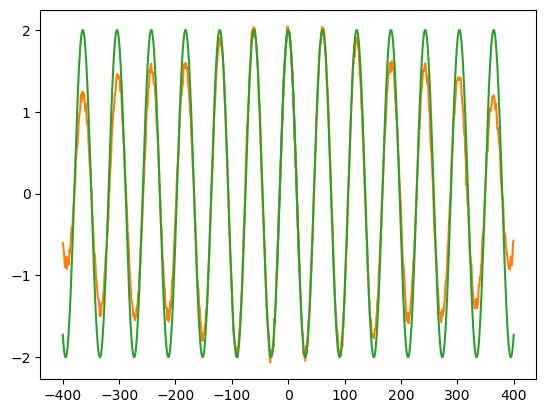

In [23]:
plt.plot(np.arange(-20, 21), X_val_tensor[18, :].detach())
plt.plot(np.arange(-400, 401), model_superresolution(X_val_tensor[18, :]).detach())
plt.plot(np.arange(-400, 401), Y_val_tensor[18, :].detach())

In [24]:
torch.save(model_superresolution.state_dict(), "model_params")